# AI RADIOLOGY

# Importing Required Libraries

In [1]:
!pip3 install pandas
!pip3 install opencv-python
!pip3 install seaborn
!pip3 install sklearn

import numpy as np
import pandas as pd
import re
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import sys
import os
from os import mkdir, makedirs
from os.path import exists

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet201,preprocess_input,decode_predictions
#from keras.applications.vgg16 import VGG16,preprocess_input,decode_predictions

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
from glob import glob

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


# Looking data directory

In [3]:
os.listdir()

['dataprodMURA-v1.1',
 'Val_Sample_merge_shoulder.csv',
 'image3-circle.png',
 'Sample_merge_wrist.csv',
 'Sample_merge_shoulder.csv',
 'image8-circle.png',
 'Val_Sample_merge_wrist.csv',
 '.git',
 '.ipynb_checkpoints',
 'image2-circle.png',
 'README.md',
 'Train_image_df.csv',
 'image9-circle.png',
 'image10-circle.png',
 'image4-circle.png',
 'Val_image_df.csv',
 'image11-circle.png',
 'image5-circle.png',
 '.gitattributes',
 'Data_load_jj.ipynb',
 'image1-circle.png',
 'image6-circle.png',
 'image7-circle.png',
 'Sample_merge.csv',
 'MURA-v1.1']

In [4]:
DATASET_PATH = "MURA-v1.1/"
os.listdir(DATASET_PATH)


def treeStructure(startpath):

    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 2 * (level)
        print('{}|'.format(indent[:]))
        print('{}+{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 2 * (level + 1)

        for f in files:
            print('   {}| +--- {}'.format(subindent[:-5], f))
        
        
            
treeStructure(DATASET_PATH)

|
+/
   | +--- train_image_paths.csv
   | +--- train_labeled_studies.csv
   | +--- valid_labeled_studies.csv
   | +--- valid_image_paths.csv
|
+train/
  |
  +XR_HUMERUS/
    |
    +patient02863/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient02898/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient02834/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient03184/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient01482/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient02789/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient02798/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient02876/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- i

    |
    +patient03048/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient03201/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient03050/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient02717/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient02822/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient03034/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient02911/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient03162/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient03169/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient01624/
      |
      +study1_positive

      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient02756/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient03158/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient02966/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient03009/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient03041/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient02741/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient03006/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient02905/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient03020/
      |

    |
    +patient03017/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient03151/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient03042/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient02733/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient00466/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient03078/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient03077/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient03045/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient02988/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient02827/
      |
      +study1_positive/
      | +--- image1.pn

      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient02979/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient00077/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient02968/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient02926/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient02969/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient02982/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient02836/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient02626/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient03012/
      |
      +study1_negative/
      | +--- image1.png

    |
    +patient01944/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient02888/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient01856/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient02817/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient02918/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient03099/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient02232/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient02829/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient02980/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient02776/
      |
      +study1_positive

    |
    +patient00584/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient07911/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient07555/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient08102/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient06449/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient08495/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient06848/
      |
      +study1_positive/
      | +--- image1.png
    |
    +patient06750/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient06920/
      |
      +

      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient06842/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient07552/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient07450/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient07753/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient06459/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient08493/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient08009/
      |
      +study1_negative/
      | +--- image1.png
      | +--- imag

    |
    +patient07683/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient08155/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient07799/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient08339/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient01486/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient07394/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient06749/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient07383/
      |
      +study1_positive/
      | +--- ima

    |
    +patient08875/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient07795/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient06777/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient03082/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient08379/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient06420/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient08120/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient08320/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patie

      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient06397/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient06645/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient06774/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient06456/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient08838/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient06398/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient02766/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient08337/
      |
      +study1_negative/
      | 

    |
    +patient06796/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient07280/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient07433/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient06356/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient08097/
      |
      +study2_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
      | +--- image5.png
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient06488/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient06787/
      |
      +study1_pos

    |
    +patient07238/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient07748/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient07237/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient01821/
      |
      +study2_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient06431/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient07846/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient05855/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient07919/
      |
      +study1_negative/
      | 

    |
    +patient07002/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient07378/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient02308/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient08756/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient01541/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient09027/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient04196/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient06482/
      |
      +study2_negative/
      | +--- image1.png
      | +--- ima

    |
    +patient07673/
      |
      +study2_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient07987/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient06839/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient08297/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient02912/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient08281/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient07443/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- imag

    |
    +patient07287/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient08978/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient07833/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient08224/
      |
      +study2_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient08760/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient06866/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient06972/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient08891/
      |
      +s

    |
    +patient06386/
      |
      +study2_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient08234/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient06462/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient07284/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient06792/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient07327/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient08586/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- imag

    |
    +patient08685/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient07811/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient07217/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient07891/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient06394/
      |
      +study2_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient08441/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
      | +--- image6.png
      | +--- image5.png
      | +--- image7.png
    |
    +patient07283/
      |
      +study1_pos

      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient06470/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient08008/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient09050/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient06460/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient08158/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient06924/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient07136/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patien

    |
    +patient06725/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient07999/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient09008/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient08996/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient01158/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient07870/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient07820/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient07258/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- ima

      |
      +study3_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient08971/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient06689/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient07732/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient08273/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient07599/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient07751/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient07560/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient00586/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient07663/
      |
      +study1_negative/

    |
    +patient02150/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient08136/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient08698/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient06417/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient06687/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient03060/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient06746/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient06121/
      |
      +study1_positive/
      | +--- ima

    |
    +patient08004/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient07979/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient06932/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient08264/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient06646/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient07385/
      |
      +study2_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient06550/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient08394/
      |
      +s

    |
    +patient07149/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient07073/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient08727/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient08792/
      |
      +study2_negative/
      | +--- image1.png
      | +--- image2.png
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient08253/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient06494/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient07850/
      |
      +study2_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient07337/
      |


    |
    +patient04349/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient07882/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient07248/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient05353/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient07596/
      |
      +study2_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient07522/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient08793/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient08494/
      |
      +s

    |
    +patient08880/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient01761/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient04479/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient07603/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient07816/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient05725/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient07809/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient06656/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient07212/
      |
      +study1_positive/
      | +--- image1.png
      |

      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient07105/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient07091/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient07123/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient08360/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient07874/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient08704/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient08898/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient06739/
      |
      +study1_positive/
      | 

    |
    +patient01215/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient06565/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient06776/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient07886/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient08049/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient06905/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient07309/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient08682/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- ima

    |
    +patient06392/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient00479/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient09016/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient07037/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient07182/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient06008/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
      | +--- image5.png
    |
    +patient06771/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient00233/
      |
      +study1_po

      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient05756/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient08485/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient08390/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient08134/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient00512/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient05374/
      |
      +study2_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image

      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient07407/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient06374/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient03129/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient07564/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient07168/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient06575/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient06806/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient06722/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | 

      |
      +study2_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient07647/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient07530/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient00266/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient03001/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient00936/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient06578/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient07071/
      |
      +study1_positive/
      | +

    |
    +patient06399/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient07701/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient06266/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient08245/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient01489/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient06436/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient08574/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient08408/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patie

    |
    +patient04538/
      |
      +study2_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
      |
      +study1_positive/
      | +--- image1.png
    |
    +patient06184/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient07923/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient01369/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient01008/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient05677/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient07659/
      |
      +study1_negative/
      | +--- imag

    |
    +patient00457/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient08038/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient08056/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient08218/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient06850/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient07823/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient07354/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient05232/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient08305/
      |
      +

    |
    +patient06472/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient08178/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient08188/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient00116/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient07913/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient07243/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient07652/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient05045/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient07728/
      |
      +

    |
    +patient03616/
      |
      +study2_negative/
      | +--- image1.png
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient08584/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient07499/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient07133/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient08096/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient06872/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient07492/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient07291/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | 

      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient07297/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient06450/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient08124/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient04810/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient07770/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient08091/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient06498/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- imag

    |
    +patient09010/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient07316/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient06400/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient07672/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient02685/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient08121/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient02462/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient08846/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient07054/
      |
      +

    |
    +patient07897/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient08103/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient08593/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
      | +--- image6.png
      | +--- image5.png
      | +--- image7.png
    |
    +patient06698/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient07487/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient06557/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient07955/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient08255/


    |
    +patient09055/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient07888/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient07021/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient04071/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient07534/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient01032/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient08837/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient08373/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient03124/
      |
      +

    |
    +patient07507/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient06484/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient05976/
      |
      +study2_negative/
      | +--- image1.png
      | +--- image2.png
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient02212/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient07350/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient08126/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient08381/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient02582/
      |
      +study1_negative/
      | 

  |
  +XR_ELBOW/
    |
    +patient05952/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient06150/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient05949/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient05810/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient00377/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient05800/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient06131/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient05297/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient04174

    |
    +patient05164/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient05339/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient05556/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient05748/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient06315/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient03492/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
      | +--- image5.png
    |
    +patient04969/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient05512/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient05352/
      |
      +

    |
    +patient05320/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient04998/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient06167/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient04963/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
      | +--- image5.png
    |
    +patient04971/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient05921/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient04109/
      |
      +study2_negative/
      | +--- image1.png
      | +--- image2.png
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient02706/
      |
      +study2_negative/
      | 

    |
    +patient06321/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient05760/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient05929/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient03801/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient06356/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient05420/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient05415/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient05750/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient01386/
      |
      +

      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient05107/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient05197/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient06202/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient06333/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient05963/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient01830/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient06340/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient05863/
      |
      +s

      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient05243/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient06018/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient04942/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient05047/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient05324/
      |
      +study1_positive/
      | +--- image1.png
    |
    +patient04916/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient06082/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patien

      | +--- image2.png
      | +--- image4.png
    |
    +patient05194/
      |
      +study1_positive/
      | +--- image1.png
    |
    +patient03592/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient05004/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient05056/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient04965/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient05535/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient05698/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient06055/
      |
      +study1_negative/
      | +--- ima

    |
    +patient05523/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient05109/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient06054/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient01112/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient05868/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient05620/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient05507/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient06026/
      |
      +study1_ne

    |
    +patient03557/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient05307/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient06121/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient05581/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient06264/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient06329/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient05328/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient04244/
      |
      +study1_negative/
      | +--- ima

      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient04884/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient05186/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient05368/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient06216/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient04997/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient05831/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient04669/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient01134/
      |
      +study1_negative/
      | 

      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient05674/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient05087/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient05992/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient05070/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient05343/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient05457/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient00956/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient05500/
      |
      +study1_negative/
      | +--- image1.png
      | 

    |
    +patient05108/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient04641/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient06354/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient05068/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient05211/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient05125/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient03063/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient04839/
      |
      +study1_negative/
      | +--- image1.png
      | +--- ima

      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient06233/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient05490/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient02316/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient03745/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient05064/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient05111/
      |
      +study2_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
      | +--- image5.png
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
      | +--- image5.png
    |
    +patient

    |
    +patient05510/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient06256/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient05398/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient03096/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient04990/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient06099/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient03663/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient06174/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient05052/
      |
      +

    |
    +patient06280/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient06259/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient05950/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient05003/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient00511/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient05282/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient05972/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient05623/
      |
      +study1_ne

      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient05525/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient05766/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient06236/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient05604/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient05373/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient04849/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient05090/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient06149/
      |
      +study1_negative/
      | +--- image1.png
      | 

    |
    +patient05212/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient05358/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient05251/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient06241/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient04910/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient05518/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient01773/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
      | +--- image5.png
    |
    +patient06086/
      |
      +study1_negative/
      | +--- image1.png
      | +--- ima

    |
    +patient04856/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient05440/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient05993/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient05450/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient05063/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient04912/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient05862/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient03092/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- ima

    +patient05669/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient05119/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient05544/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient02265/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient04967/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient00918/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient05505/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient06049/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.pn

    |
    +patient00138/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient01196/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient00376/
      |
      +study2_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient02646/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient00388/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
      | +--- image6.png
      | +--- image5.png
    |
    +patient01449/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient01273/
 

    |
    +patient02418/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient00777/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient00881/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient01891/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient01245/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient01077/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient02240/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient00489/
      |
      +study1_positive/
      | +--- ima

    |
    +patient01521/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient00646/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient02408/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient01903/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient00776/
      |
      +study1_positive/
      | +--- image1.png
    |
    +patient00525/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient01486/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient00084/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patie

    |
    +patient01598/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient01443/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient00305/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient00799/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient02627/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient01255/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient01508/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient01206/
      |
      +study1_positive/
      | +--- ima

      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient01703/
      |
      +study2_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient02162/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient01376/
      |
      +study1_positive/
      | +--- image1.png
    |
    +patient02199/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient02093/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient02047/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient00075/
      |
      +study1_positive/
      | +

    |
    +patient01481/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient00490/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient01526/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient01264/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient02065/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient02070/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient01624/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient01699/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- ima

    |
    +patient01738/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient01785/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient01199/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient00131/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient00001/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient01044/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient00259/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient02102/
      |
      +study1_negative/
      | +--- image1.png
      | +--- ima

    |
    +patient00870/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient01230/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient01220/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient00892/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient00560/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient01065/
      |
      +study1_positive/
      | +--- image1.png
    |
    +patient00101/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient02227/


      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
      | +--- image5.png
    |
    +patient00113/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient01601/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient00019/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient01916/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient00470/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient00528/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient01549/
      |
      +study1_negative/
      | +--- image1.png
      | +--- imag

      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient00459/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient02369/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient02389/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient01301/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient00659/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient00083/
      |
      +study1_positive/
      | +--- image1.png
    |
    +patient01733/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient02023/
      |
      +s

    |
    +patient00415/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient00827/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient01280/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient00133/
      |
      +study1_positive/
      | +--- image1.png
    |
    +patient02635/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient02427/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
      | +--- image5.png
    |
    +patient01112/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient00231/
      |
      +study1_positive/
      | +--- image1.png
      | +--- ima

    |
    +patient01097/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient02480/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient02304/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient01849/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient02054/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient01954/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient00869/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient00586/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patie

    |
    +patient02348/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient02086/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient01911/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient02459/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient02659/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient01337/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient00759/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
      | +--- image5.png
    |
    +patient01100/
      |
      +study1_po

    |
    +patient02003/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient00843/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient02016/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient02355/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient01455/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient00372/
      |
      +study1_positive/
      | +--- image1.png
    |
    +patient00785/
      |
      +study1_positive/
      | +--- image1.png
    |
    +patient00469/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient00339/
      |
      +study1_positive/
      |

    |
    +patient00262/
      |
      +study1_positive/
      | +--- image1.png
    |
    +patient02661/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient01809/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient02285/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient01439/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient02604/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient02512/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient00275/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- ima

    |
    +patient00899/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient02197/
      |
      +study1_negative/
      | +--- image11.png
      | +--- image1.png
      | +--- image3.png
      | +--- image10.png
      | +--- image9.png
      | +--- image2.png
      | +--- image4.png
      | +--- image8.png
      | +--- image6.png
      | +--- image5.png
      | +--- image7.png
    |
    +patient02039/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient01087/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient02196/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient01411/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | 

    |
    +patient02165/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient00199/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient00335/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient02407/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient02055/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient00561/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient01966/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient01504/
      |
      +study1_negative/
      | +--- ima

    |
    +patient00828/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient00311/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient01858/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient01879/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient01975/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient01677/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient02662/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient01829/
      |
      +study1_negative/
      | +--- ima

    |
    +patient00256/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient01818/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient02323/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient00214/
      |
      +study2_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient01913/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient01909/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient00604/
      |
      +study2_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      |
      +study1_positive/
      | +

    |
    +patient02342/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient00882/
      |
      +study1_positive/
      | +--- image1.png
    |
    +patient01191/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient00304/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient01223/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient02063/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient00524/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient02560/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- ima

    |
    +patient02393/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient00081/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient01398/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient02612/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient02606/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient00188/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient00479/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient00574/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patie

      | +--- image2.png
    |
    +patient00201/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient00145/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient02539/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient01700/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient02553/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient01135/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient01233/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient01645/
      |
      +study1_negative/
      | +--- image1.png
      | +--- ima

    |
    +patient01876/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient00155/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient01485/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient01976/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient00103/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient02555/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient00685/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient01929/
      |
      +study1_negative/
      | +--- ima

    |
    +patient01894/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient01141/
      |
      +study1_positive/
      | +--- image1.png
    |
    +patient02483/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient00418/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient00032/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient01772/
      |
      +study2_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
      |
      +study3_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient00034/
      |
      +study1_positive/
      | +

    |
    +patient00476/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient00511/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient00705/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient00846/
      |
      +study2_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
      | +--- image5.png
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient02075/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient00210/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient01998/
 

    |
    +patient01571/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient01364/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient02651/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient01606/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient01730/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient00020/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient02271/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient01059/
      |
      +study1_positive/
      | +--- ima

      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient00315/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient00117/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient01105/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
      | +--- image5.png
    |
    +patient01159/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient01568/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient01379/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient00855/
      |
      +study1_positive/
      | +--- imag

      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient01321/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient02493/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient02019/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient01652/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient00642/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient00088/
      |
      +study2_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      |
      +study1_positive/
      | +--- image1.png
    |
    +patient

    |
    +patient01576/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient00443/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient01299/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient00393/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient01667/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient01294/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
      | +--- image5.png
    |
    +patient02372/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient01640/


    |
    +patient01595/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient02158/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient00774/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient01310/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
      | +--- image5.png
    |
    +patient00941/
      |
      +study1_positive/
      | +--- image1.png
    |
    +patient01755/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
      | +--- image5.png
    |
    +patient01798/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient01069/


    |
    +patient00747/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient01488/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient01944/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient02002/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient01277/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient01834/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient01886/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
      | +--- image5.png
 

    |
    +patient02339/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient02365/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient02256/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient00748/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient01020/
      |
      +study1_positive/
      | +--- image1.png
    |
    +patient00541/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient01462/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient01334/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient02382/
      |
      +

    |
    +patient02575/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient01293/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient02472/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient01203/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient02204/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient02049/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient00755/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient00076/
      |
      +study1_positive/
      | +--- image1.png
      | +--- ima

      | +--- image3.png
      | +--- image2.png
    |
    +patient00017/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient02647/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient00292/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient01845/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient00337/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient00624/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient01399/
      |
      +study1_positive/
      | +--- image1.png
    |
    +patient00721/
      |
      +study1_positive/
      | +--- ima

    |
    +patient10882/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient10513/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient10209/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient03492/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient10812/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient10149/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient02694/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient09956/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient10152/
      |
      +

      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient10114/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient09826/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient10247/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient09821/
      |
      +study2_negative/
      | +--- image1.png
      | +--- image2.png
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient01969/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient10309/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient10355/
      |
      +study1_negative/
      | +--- image1.png
      | +

      |
      +study1_negative/
      | +--- image1.png
    |
    +patient09786/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient10701/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient10922/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient10904/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient11170/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient09875/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient10541/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient01546/
      |
      +study1_negative/
      | +--- image1.png
      | 

      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient10058/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient10177/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient10828/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient10113/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient10969/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient10674/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient09874/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient01793/
      |
      +study2_negative/
      | +--- image1.png
      | +--- image3.png
      | 

      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient02186/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient10470/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient10847/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient05524/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient10028/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient10322/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient10098/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient05735/
      |
      +s

    |
    +patient02220/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient10382/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient10673/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient11029/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient11184/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient10184/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient10825/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient02812/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- ima

    |
    +patient10059/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient10587/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient03867/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient06162/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient10468/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient10944/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient04569/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient10401/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- ima

      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient00633/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient10148/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient09748/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient02464/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient10801/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient07140/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient09919/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient11133/
      |
      +s

    |
    +patient08792/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient10394/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient10214/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient09913/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient10741/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient01505/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient09302/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient10335/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient00141/
      |
      +

    |
    +patient04017/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient07835/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient10112/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient10288/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient09862/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient10374/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient10395/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient09815/
      |
      +study2_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      |
      +s

    |
    +patient09844/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient10990/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient06090/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient11152/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient09896/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient09855/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient10908/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient10095/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- ima

      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient11158/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient09879/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient10819/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient10930/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient09816/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient10661/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient10994/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient11174/
      |
      +s

    |
    +patient06694/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient10921/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient09836/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient07033/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient09965/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient10813/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient10787/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient01009/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patie

    |
    +patient09825/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient10364/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient05136/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient10147/
      |
      +study2_negative/
      | +--- image1.png
      | +--- image2.png
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient10017/
      |
      +study2_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient00303/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient10672/
      |
      +study1_negative/
      | +--- image1.png
      | +

    |
    +patient10420/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient09885/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient09933/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient01474/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient09887/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient11145/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient10370/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient09827/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patie

      |
      +study2_negative/
      | +--- image1.png
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient10574/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient01019/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient09994/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient10688/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient09806/
      |
      +study2_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient05988/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient09749/
      |
 

    |
    +patient10398/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient05897/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient10568/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient10166/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient01488/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient05822/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient10239/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient10748/
      |
      +study1_negative/
      | +--- image1.png
      | +--- ima

    |
    +patient10357/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient10318/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient01972/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient11042/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient04271/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient10962/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient10365/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient09944/
      |
      +study2_negative/
      | +--- image1.png
      | +--- image2.png
      |
      +study1_positive/
      | 

      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient05405/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient10381/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient05916/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient10519/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient09957/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient10957/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient09962/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient11052/
      |
      +study1_negative/
      | 

    |
    +patient03774/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient04339/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient03847/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient02794/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient03809/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient00861/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient04858/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient03658/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient04382/
      |
      +

    |
    +patient03662/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient03926/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient03927/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient04416/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient04361/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient04003/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient03396/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient04658/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient03728/
      |
      +

      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient04053/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient03443/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient04757/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient04250/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient04252/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient04575/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient04058/
      |
      +study2_negative/
      | +--- image1.png
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +

      | +--- image2.png
    |
    +patient03400/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient04515/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient00238/
      |
      +study2_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient04381/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient04808/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient04518/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient02754/
      |
      +study1_negative/
      | +--- imag

      | +--- image3.png
      | +--- image2.png
    |
    +patient04212/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient04577/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient03963/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient03659/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient03390/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient02258/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient04475/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient03629/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient03547/
      |
      +

      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient04576/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient04768/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient04720/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient03951/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient04045/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient04812/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient04136/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient04319/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient01750/
      |

    |
    +patient04689/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient03250/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient03725/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient04855/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient02094/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient04035/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient03867/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient04569/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient02940/
      |
      +study1_negative/
      |

    |
    +patient02132/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient04444/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient04148/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient02363/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient04244/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient04778/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient04562/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient04549/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient03893/
      |
      +study1_negative/
      |

      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient00643/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient02867/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient04120/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient02920/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient03408/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient04223/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient04333/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient04104/


    |
    +patient03003/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient04694/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient04691/
      |
      +study2_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient04480/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient03832/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient04182/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient03684/
      |
      +study2_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      |
      +study1_positive/
      | +--- image1.png
      | +

    |
    +patient04514/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient01875/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient04328/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient04820/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient04265/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient03952/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient01524/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient03938/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient04048/
      |
      +study1_negative/
      |

    |
    +patient03451/
      |
      +study1_positive/
      | +--- image1.png
    |
    +patient03733/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient04713/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient03891/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient03619/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient04731/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient02566/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient03325/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient03524/
      |
      +

    |
    +patient04494/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient03370/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient04004/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient04608/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient03419/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient03740/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient03945/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient04345/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient03467/
      |
      +

    |
    +patient03642/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient04618/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient04817/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient03530/
      |
      +study2_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient03883/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient03914/
      |
      +study2_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient01931/
      |
      +study1_positive/
      | +--- image1.png
    |
    +patient04469/
      |


      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient01478/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient04424/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient03261/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient03461/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient04413/
      |
      +study2_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient04506/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient

    |
    +patient03928/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient04275/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient03692/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient03522/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient04084/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient00929/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient04478/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient03616/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient04726/
      |
      +

    |
    +patient04772/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient04363/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient04432/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient03857/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient04794/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient03586/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient04263/
      |
      +study2_negative/
      | +--- image1.png
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient03723/
      |
      +study1_positive/
      | 

    |
    +patient01458/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient04615/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient04598/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient03445/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient03604/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient03762/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient04267/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient00905/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patie

    |
    +patient04251/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient03825/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient03466/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient04850/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient04423/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient04117/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient03252/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient04013/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient04755/
      |
      +study1_negative/
      | +--- image1.png
      |

    |
    +patient09260/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient09147/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient09557/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient06113/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient09420/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient09224/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient04626/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient09585/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient09543/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient09607/
      |
      +study1_negative

      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient09352/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient09548/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient08872/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient04617/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient09342/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient02558/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient09170/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient09293/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient09229/
      |

    |
    +patient08273/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient09228/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient09727/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient09676/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient09273/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient03834/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient09351/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient09091/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient03562/
      |
      +study1_negative/
      | +--- image1.png
    |
 

      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient09181/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient09234/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient09546/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient09277/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient09203/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient09555/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient04017/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient03956/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient03841/
      |

    |
    +patient08601/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient09162/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient04160/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient09438/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient09633/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient00284/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient09338/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient09467/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient09603/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient09657/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient0960

    |
    +patient09628/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient09407/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient06709/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient09384/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient04402/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient09687/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient09456/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient05150/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient09161/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
      | +--- image5.png
    |
    +patient02127/
      

    |
    +patient03303/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient09112/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient09617/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient06858/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient09714/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient09570/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient02724/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient09721/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient09232/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient09463/
      

    |
    +patient11629/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient11523/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient11699/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient11635/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient11621/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient11684/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient11644/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient11672/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient11631/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient11615/
      |
      +study1_positive

    |
    +patient11368/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient11209/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient11229/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient11281/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient11372/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient11204/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient11348/
      |
      +study2_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- imag

    |
    +patient11219/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient11197/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient11385/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient11302/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient11269/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient11382/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient11299/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient11303/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patie

      |
      +study2_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient11257/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient11318/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient11359/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient11353/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient11369/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient11276/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient11297/
      |
      +study1_negative/
      | +--- image1.png
      | +

      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient11569/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient11534/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient11711/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient11342/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient11804/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient11389/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient11867/
      |
      +study1_negative/
      | +--- image1.png
      | +--- imag

    |
    +patient11368/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient11281/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient11789/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient11790/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient11204/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient11348/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient11695/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient11751/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient11676/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      |

      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient11781/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient11267/
      |
      +study2_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient11734/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient11760/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient11792/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient11563/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient11722/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
   

      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient11300/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient11607/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient11515/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient11556/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient11503/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient11526/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient11275/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patien

      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient11383/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient11496/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient11955/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient11723/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient11598/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient11924/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient11904/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient11908/
      |
      +s

    |
    +patient11423/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
      | +--- image4.png
    |
    +patient11435/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient11425/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient11405/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient11456/
      |
      +study1_negative/
      | +--- image1.png
      | +--- image2.png
    |
    +patient11470/
      |
      +study1_negative/
      | +--- image1.png
    |
    +patient11429/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image2.png
    |
    +patient11398/
      |
      +study1_positive/
      | +--- image1.png
      | +--- image3.png
      | +--- image2.png
    |
    +patient11496/
      |
      +study1_negative/
      | +--- image1.png
      |

# Load, Merge & Extract feature to CSV

In [5]:
Train_image_df = pd.read_csv(DATASET_PATH + 'train_image_paths.csv', header = None, names = ["Image_Path"])

Val_image_df  = pd.read_csv(DATASET_PATH + 'valid_image_paths.csv', header = None, names = ["Image_Path"])

In [6]:
Train_image_df.shape

(36808, 1)

In [7]:
Val_image_df.shape

(3197, 1)

In [8]:
def generate_labels(data):
    '''Extract label value fromfile path'''
    Labels = []
    
    for idx,row in data.iterrows():
        match = re.search(r'\w(positive)',row[-1]) #regex for str 'positive'
        if match:
            Labels.append('1')
        else:
            Labels.append('0')
    return Labels

def generate_body_part(data):
    '''Extract body part fromfile path'''
    Body_Part = []
    
    for idx,row in data.iterrows():
        match2 = re.search(r'/.*/(.*)/.*/.*/',row[-1])
        body_part_str = match2.group(1)
        Body_Part.append(body_part_str.split('_')[1])
    return Body_Part

def generate_study_type(data):
    '''Extract study type fromfile path'''
    Study_Type = []
    
    for idx,row in data.iterrows():
        match3 = re.search(r'/.*/.*/.*/(.*)/',row[-1]) 
        study_string = match3.group(1)
        Study_Type.append(study_string.split('_')[0])
    return Study_Type

train_labels = generate_labels(Train_image_df)
train_part   = generate_body_part(Train_image_df)
train_study  = generate_study_type(Train_image_df)

Train_image_df['Label']     = train_labels
Train_image_df['Body_Part'] = train_part
Train_image_df['Study_Type']= train_study


val_labels = generate_labels(Val_image_df)
val_part   = generate_body_part(Val_image_df)
val_study  = generate_study_type(Val_image_df)

Val_image_df['Label']      = val_labels
Val_image_df['Body_Part']  = val_part
Val_image_df['Study_Type'] = val_study

In [9]:
Train_image_df[:5]

,Image_Path,Label,Body_Part,Study_Type
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,SHOULDER,study1
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,SHOULDER,study1
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,SHOULDER,study1
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1,SHOULDER,study1
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1,SHOULDER,study1


# Exploratory Analysis

<AxesSubplot:xlabel='Body_Part'>

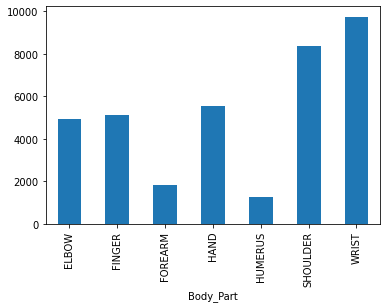

In [10]:
Plt_1 = Train_image_df.groupby(['Body_Part']).size()
Plt_1.plot.bar(x='Body_Part', rot=90)

In [11]:
Train_image_df.groupby(['Study_Type']).size()

Study_Type
study1    35331
study2     1340
study3      109
study4       28
dtype: int64

In [12]:
Train_image_df.groupby(['Body_Part','Label']).count()

Image_Path  Study_Type
Body_Part Label                        
ELBOW     0            2925        2925
          1            2006        2006
FINGER    0            3138        3138
          1            1968        1968
FOREARM   0            1164        1164
          1             661         661
HAND      0            4059        4059
          1            1484        1484
HUMERUS   0             673         673
          1             599         599
SHOULDER  0            4211        4211
          1            4168        4168
WRIST     0            5765        5765
          1            3987        3987

In [13]:
Val_image_df[:5]

,Image_Path,Label,Body_Part,Study_Type
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1,WRIST,study1
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1,WRIST,study1
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1,WRIST,study1
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1,WRIST,study1
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,1,WRIST,study1


In [14]:
Val_image_df.shape

(3197, 4)

Fetching sample records

In [15]:
Sample_df = Train_image_df.groupby(['Label'],group_keys=False).apply(lambda x: x.sample(8000,replace=True))
Sample_df.head()

,Image_Path,Label,Body_Part,Study_Type
26176,MURA-v1.1/train/XR_WRIST/patient08169/study1_n...,0,WRIST,study1
25780,MURA-v1.1/train/XR_WRIST/patient06065/study1_n...,0,WRIST,study1
19116,MURA-v1.1/train/XR_ELBOW/patient06181/study1_n...,0,ELBOW,study1
34230,MURA-v1.1/train/XR_HAND/patient10496/study1_ne...,0,HAND,study1
35081,MURA-v1.1/train/XR_HAND/patient04843/study1_ne...,0,HAND,study1


Data Visulaization

<AxesSubplot:xlabel='Label', ylabel='count'>

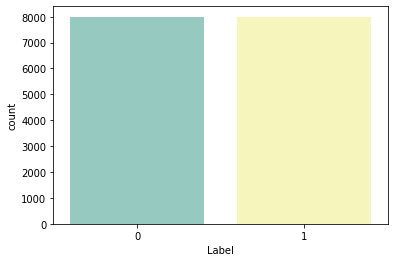

In [16]:
sns.countplot(Sample_df['Label'], palette="Set3")

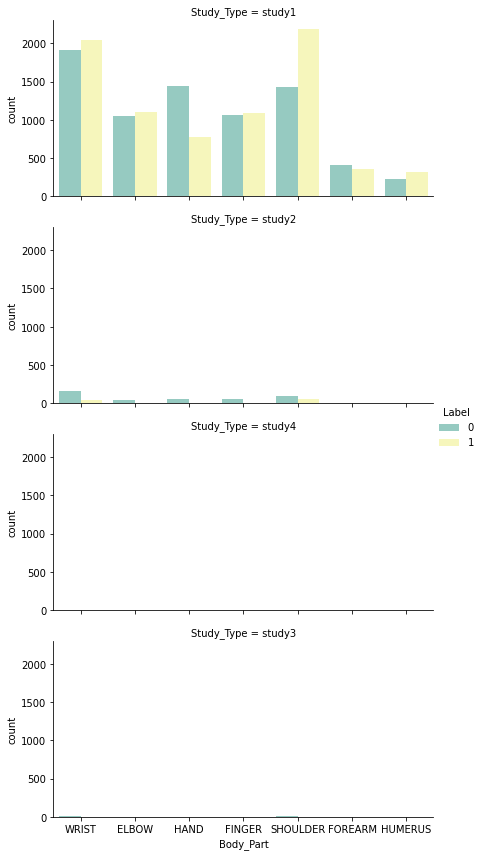

In [17]:
sns.catplot(x="Body_Part", hue="Label", palette="Set3", col="Study_Type",col_wrap=1,

                data=Sample_df, kind="count",

                height=3, aspect=2);

<AxesSubplot:xlabel='Label', ylabel='count'>

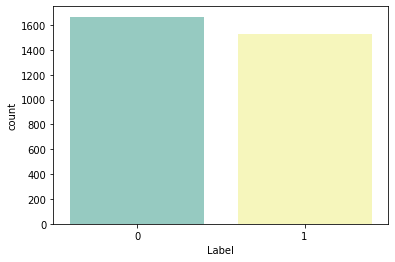

In [18]:
sns.countplot(Val_image_df['Label'], palette="Set3")

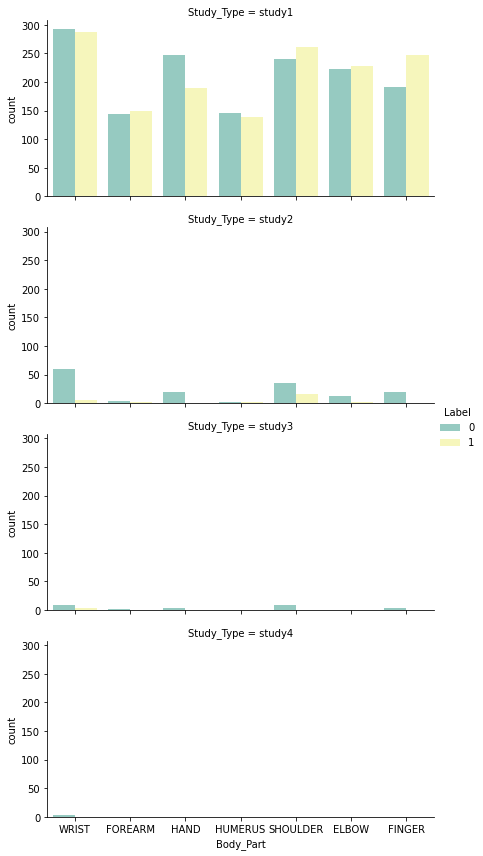

In [19]:
sns.catplot(x="Body_Part", hue="Label", palette="Set3", col="Study_Type",col_wrap=1,

                data=Val_image_df, kind="count",

                height=3, aspect=2);

# Data Preprocessing

In [20]:
crop_size = 256
def csv_process(csv_name, out_dir):
    with open(csv_name, 'r') as csvfile:
        img_reader = csv.reader(csvfile)
        for row in img_reader:
            filename = row[0][0:]
            filename_in = filename
            filename_out = out_dir + filename

            #print(filename_in,filename_out)
            preprocess(filename_in, filename_out)

def preprocess(filename_in, filename_out):

    img = cv2.imread(filename_in, cv2.IMREAD_GRAYSCALE)
    m, n = img.shape

    img = cv2.resize(img, (256, 256))
        
    img = crop_center_with_scale(cv2.resize(img, (320, 320)), 256, 256)
   
    (head, tail) = os.path.split(filename_in)
    (root, ext) = os.path.splitext(tail)
    

    filename_out_cir = root + "-circle" + ext

    img = cv2.imread(filename_in, cv2.IMREAD_GRAYSCALE)
    
    edge_finder = cv2.Canny(img, threshold1=50, threshold2=118)

    cv2.imwrite(filename_out_cir, edge_finder)


    x, y = find_act(edge_finder)
    create_path(filename_out)
    cv2.imwrite(filename_out, img[x: x+crop_size, y:y+crop_size])
    
    
def find_act(img):
    img = img.astype(np.int32)
    kernel = np.ones((crop_size, crop_size), img.dtype)
    cnt = np.zeros((crop_size, crop_size), dtype = img.dtype)
    cnt = cv2.filter2D(img, -1, kernel, anchor=(0, 0))
    s = np.argmax(cnt)
    n, m = img.shape
    x = int(s/n)
    y = int(s%m)
    if x+crop_size>n:
        x = n-crop_size
    if y+crop_size>m:
        y = m-crop_size

    return x, y

def create_path(s):
    p = s.rfind("/")
    mk = s[: p]
    if not exists(mk):
        makedirs(mk)
        

def crop_center_with_pixel(img,cropx,cropy):
    y,x= img.shape
    startx = x//2 - cropx//2
    starty = y//2 - cropy//2    
    return img[starty:starty+cropy, startx:startx+cropx]


def crop_center_with_scale(img,scalex,scaley):
    y,x= img.shape
    cropx = int(x*scalex)
    cropy = int(y*scaley)
    return crop_center_with_pixel(img, cropx, cropy)

In [21]:

Train_image_df.to_csv('Train_image_df.csv',index=False,header=False)
csv_process('Train_image_df.csv', 'dataprod')

Val_image_df.to_csv('Val_image_df.csv',index=False,header=False)
csv_process('Val_image_df.csv', 'dataprod')

# Image Generator

Found 36808 validated image filenames belonging to 2 classes.
Found 3197 validated image filenames belonging to 2 classes.


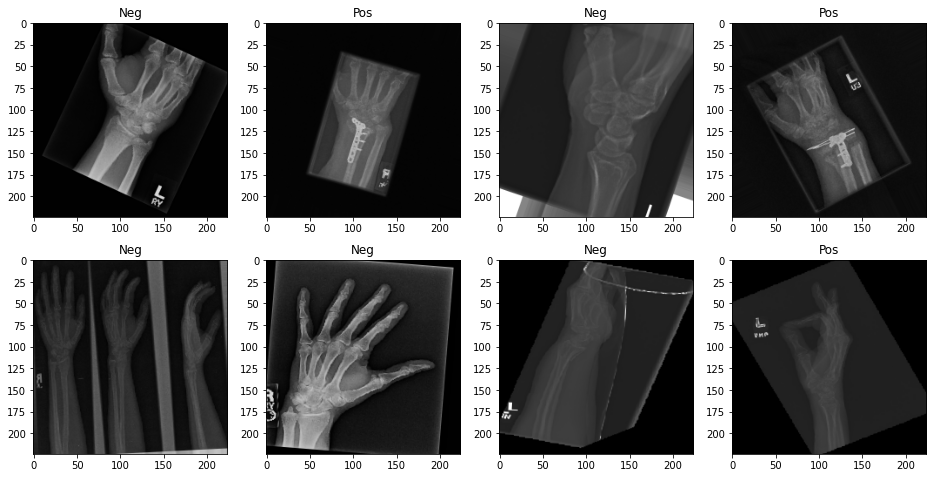

In [32]:
Data_generation_fl = ImageDataGenerator(
                       rescale = 1. / 255,
                       horizontal_flip=True,
                       rotation_range=30,
                       fill_mode ='nearest'
                       )
Data_generation_fl.mean = np.array([0.485, 0.456, 0.406], dtype=np.float32).reshape((1,1,3)) # ordering: [R, G, B]
Data_generation_fl.std = np.array([0.229, 0.224, 0.225], dtype=np.float32).reshape((1,1,3)) # ordering: [R, G, B]


train_gen_fl = Data_generation_fl.flow_from_dataframe(Train_image_df,
                                         x_col='Image_Path',
                                         y_col='Label',
                                        color_mode='rgb',
                                         target_size=(224, 224),
                                         class_mode='binary',
                                         batch_size = 8)
t_x,t_y=next(train_gen_fl)


fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,:])
    c_ax.set_title('%s' % ('Pos' if c_y>0.5 else 'Neg'))
    
valid_gen_fl = Data_generation_fl.flow_from_dataframe(Val_image_df,
                                         x_col='Image_Path',
                                         y_col='Label',batch_size =8,
                                         target_size=(224, 224),
                                         class_mode='binary')

# Train Model

In [26]:
densenet_fl = DenseNet201(weights='imagenet', include_top = False, input_shape=(224, 224, 3))

densenet_fl.trainable = False

model_fl = tf.keras.models.Sequential([
    densenet_fl,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_fl.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [33]:
model_fl.fit_generator(train_gen_fl, epochs=50, validation_data=valid_gen_fl, steps_per_epoch=len(train_gen_fl) // 8)

Epoch 1/50
575/575 [==============================] - 95s 165ms/step - loss: 3.4935 - accuracy: 0.6796 - val_loss: 3.3435 - val_accuracy: 0.6609
Epoch 2/50
575/575 [==============================] - 98s 171ms/step - loss: 3.2305 - accuracy: 0.7009 - val_loss: 2.8965 - val_accuracy: 0.6931
Epoch 3/50
575/575 [==============================] - 100s 173ms/step - loss: 3.1910 - accuracy: 0.6904 - val_loss: 3.0477 - val_accuracy: 0.6847
Epoch 4/50
575/575 [==============================] - 99s 173ms/step - loss: 3.2419 - accuracy: 0.6952 - val_loss: 3.6277 - val_accuracy: 0.6759
Epoch 5/50
575/575 [==============================] - 100s 174ms/step - loss: 3.1527 - accuracy: 0.6915 - val_loss: 3.4613 - val_accuracy: 0.6581
Epoch 6/50
575/575 [==============================] - 100s 174ms/step - loss: 3.3443 - accuracy: 0.6863 - val_loss: 3.1515 - val_accuracy: 0.6744
Epoch 7/50
575/575 [==============================] - 101s 175ms/step - loss: 3.2534 - accuracy: 0.6954 - val_loss: 3.2883 - va